In [18]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


### Loading the Files 
First, load the files and take a brief look at file contents and description. 

There are two main files : Database CPO (in GT GDrive), which contains updated information on all the CPOs and their respective contracts with GT which is updated by the commercial team. The second is the charge events excel file (download in admin.virta.fr -> download charge events (CPO)), which is a csv containing all the charge events for a give time period

note: in next versions, use scrapping to download and subtil to move to a folder

In [24]:
month = 'aout'
charge_events = pd.read_csv('cpochargeevents_01.08.2022 - 31.08.2022.csv',skiprows=1) #load the csv charge events file into pandas dataframe
charge_events.head() #see the first 5 columns of the csv file

,Created,Charge ID,Station ID,EVSE-ID,Station name,CPO name,Start time,Stop time,Duration,Energy (Wh),...,Free usage,Plug type,Charge method,Operator,Provider ID,Transaction ID,CPO share,Billing type,Location type,RFID
0,2022-08-16 15:22:22,28054331,45640,FR*EZD*E45640,Borne M. Joubert - 3kW,SURAYA,2022-08-16 15:22:22,2022-08-16 15:22:51,1,10,...,No,AC,auth_not_required_ocpp,FR*EZD,FI*VIR,26465122.0,0.0,Postpaid,Public,12345678
1,2022-08-25 23:03:49,28483424,45640,FR*EZD*E45640,Borne M. Joubert - 3kW,SURAYA,2022-08-25 23:03:49,2022-08-26 15:37:58,995,44195,...,No,AC,auth_not_required_ocpp,FR*EZD,FI*VIR,26860518.0,0.0,Postpaid,Public,12345678
2,2022-08-01 03:23:10,27306893,142517,FR*EZD*E142517,Created 2022-07-15 15:55 con: 0,SURAYA,2022-08-01 03:23:10,2022-08-01 14:58:22,696,11017,...,Yes,AC,rfid,FR*EZD,FI*VIR,25791463.0,0.0,Postpaid (by card),Public,123456789
3,2022-08-02 06:06:15,27358345,142517,FR*EZD*E142517,Created 2022-07-15 15:55 con: 0,SURAYA,2022-08-02 06:06:15,2022-08-02 15:29:41,564,4539,...,Yes,AC,rfid,FR*EZD,FI*VIR,25895168.0,0.0,Postpaid (by card),Public,123456789
4,2022-08-04 07:36:22,27456206,142517,FR*EZD*E142517,Created 2022-07-15 15:55 con: 0,SURAYA,2022-08-04 07:36:22,2022-08-04 15:49:02,493,7244,...,Yes,AC,rfid,FR*EZD,FI*VIR,25988570.0,0.0,Postpaid (by card),Public,123456789


In [20]:
charge_events.info() #see a description of the columns and data types 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5770 entries, 0 to 5769
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Created         5770 non-null   object 
 1   Charge ID       5770 non-null   int64  
 2   Station ID      5770 non-null   int64  
 3   EVSE-ID         5770 non-null   object 
 4   Station name    5770 non-null   object 
 5   CPO name        5770 non-null   object 
 6   Start time      5770 non-null   object 
 7   Stop time       5767 non-null   object 
 8   Duration        5770 non-null   int64  
 9   Energy (Wh)     5770 non-null   int64  
 10  Meter start     5770 non-null   int64  
 11  Meter stop      5770 non-null   int64  
 12  VAT P           5770 non-null   float64
 13  VAT             5770 non-null   float64
 14  Net             5770 non-null   float64
 15  Price           5770 non-null   float64
 16  Currency        5760 non-null   object 
 17  Public/Private  5770 non-null   o

### Pre-treatment

-> change Wh to kWh for visibility.


-> fix NaN Stop times

note that non-nullcount difference between start time and stop time from charge_events.info() indicate the number of 'error charges' that have to be fixed. In other words, charges that were not registered correctly, and therefore do not have a corresponding stop time. This must be fixed before making the reports - all NaN stop values should be changed to 1 hour after the start time. To do this, first change the data type of time columns to datetime, then add 1 hour to all NaN cells in the 'Stop time' column.

In [25]:
charge_events['Energy (Wh)'] = charge_events['Energy (Wh)']/1000
charge_events.rename(columns = {'Energy (Wh)':'Energy (kWh)'})

,Created,Charge ID,Station ID,EVSE-ID,Station name,CPO name,Start time,Stop time,Duration,Energy (kWh),...,Free usage,Plug type,Charge method,Operator,Provider ID,Transaction ID,CPO share,Billing type,Location type,RFID
0,2022-08-16 15:22:22,28054331,45640,FR*EZD*E45640,Borne M. Joubert - 3kW,SURAYA,2022-08-16 15:22:22,2022-08-16 15:22:51,1,0.010,...,No,AC,auth_not_required_ocpp,FR*EZD,FI*VIR,26465122.0,0.00,Postpaid,Public,12345678
1,2022-08-25 23:03:49,28483424,45640,FR*EZD*E45640,Borne M. Joubert - 3kW,SURAYA,2022-08-25 23:03:49,2022-08-26 15:37:58,995,44.195,...,No,AC,auth_not_required_ocpp,FR*EZD,FI*VIR,26860518.0,0.00,Postpaid,Public,12345678
2,2022-08-01 03:23:10,27306893,142517,FR*EZD*E142517,Created 2022-07-15 15:55 con: 0,SURAYA,2022-08-01 03:23:10,2022-08-01 14:58:22,696,11.017,...,Yes,AC,rfid,FR*EZD,FI*VIR,25791463.0,0.00,Postpaid (by card),Public,123456789
3,2022-08-02 06:06:15,27358345,142517,FR*EZD*E142517,Created 2022-07-15 15:55 con: 0,SURAYA,2022-08-02 06:06:15,2022-08-02 15:29:41,564,4.539,...,Yes,AC,rfid,FR*EZD,FI*VIR,25895168.0,0.00,Postpaid (by card),Public,123456789
4,2022-08-04 07:36:22,27456206,142517,FR*EZD*E142517,Created 2022-07-15 15:55 con: 0,SURAYA,2022-08-04 07:36:22,2022-08-04 15:49:02,493,7.244,...,Yes,AC,rfid,FR*EZD,FI*VIR,25988570.0,0.00,Postpaid (by card),Public,123456789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5765,2022-08-29 18:47:52,28653444,29134,FR*EZD*E29134,Mr Bricolage - Le Lamentin - 972 - 22kW,Mr Bricolage - Le Lamentin,2022-08-29 18:47:52,2022-08-29 19:28:10,41,14.680,...,No,AC,rfid,FR*EZD,FI*VIR,26976690.0,0.00,Prepaid,Public,E23B3A64
5766,2022-08-29 23:24:35,28663320,29134,FR*EZD*E29134,Mr Bricolage - Le Lamentin - 972 - 22kW,Mr Bricolage - Le Lamentin,2022-08-29 23:24:35,2022-08-29 23:25:43,2,0.000,...,No,AC,rfid,FR*EZD,FI*VIR,26982973.0,0.00,Prepaid,Public,14851985
5767,2022-08-30 01:07:16,28665121,29134,FR*EZD*E29134,Mr Bricolage - Le Lamentin - 972 - 22kW,Mr Bricolage - Le Lamentin,2022-08-30 01:07:16,2022-08-30 01:41:00,34,5.720,...,No,AC,rfid,FR*EZD,FI*VIR,26984426.0,2.38,Prepaid,Public,14A966D8
5768,2022-08-31 02:02:12,28716108,29134,FR*EZD*E29134,Mr Bricolage - Le Lamentin - 972 - 22kW,Mr Bricolage - Le Lamentin,2022-08-31 02:02:12,2022-08-31 02:23:04,21,7.340,...,No,AC,app,FR*EZD,FI*VIR,27025548.0,0.00,Prepaid,Public,NaN


In [26]:
time_24 = ['Created','Stop time','Start time']
charge_events[time_24] = charge_events[time_24].apply(pd.to_datetime,format = '%Y-%m-%d %H:%M:%S')
missing_stop_time_idx = np.where(charge_events['Stop time'].isnull())
charge_events['Stop time'].loc[missing_stop_time_idx] = charge_events['Start time'].loc[missing_stop_time_idx]+timedelta(hours=1) #adding 1 hour to NaN values


/home/stella/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [27]:
charge_events['Stop time'].loc[missing_stop_time_idx ]

251    2022-08-05 19:39:33
583    2022-08-03 19:40:43
1549   2022-08-24 16:44:15
Name: Stop time, dtype: datetime64[ns]

In [28]:
charge_events['Start time'].loc[missing_stop_time_idx ]

251    2022-08-05 18:39:33
583    2022-08-03 18:40:43
1549   2022-08-24 15:44:15
Name: Start time, dtype: datetime64[ns]

### CPO Groubys

In [29]:
charge_events['Date'] = charge_events['Start time'].dt.date
charge_events.groupby(['CPO name']).apply(list)

CPO name
 Philippe JOCK       [Created, Charge ID, Station ID, EVSE-ID, Stat...
AFD                  [Created, Charge ID, Station ID, EVSE-ID, Stat...
AGSEA                [Created, Charge ID, Station ID, EVSE-ID, Stat...
ARS                  [Created, Charge ID, Station ID, EVSE-ID, Stat...
AUTOS GM             [Created, Charge ID, Station ID, EVSE-ID, Stat...
                                           ...                        
Solidarité SOS       [Created, Charge ID, Station ID, EVSE-ID, Stat...
Suprim Nuisibles     [Created, Charge ID, Station ID, EVSE-ID, Stat...
Taxi Thierry Lise    [Created, Charge ID, Station ID, EVSE-ID, Stat...
Unité Sud            [Created, Charge ID, Station ID, EVSE-ID, Stat...
VILDEUIL             [Created, Charge ID, Station ID, EVSE-ID, Stat...
Length: 125, dtype: object

In [30]:
test = 'Jumbo Car Martinique'

test_CPO = charge_events.groupby(['CPO name']).get_group(test)
#test_CPO.columns
test_CPO

,Created,Charge ID,Station ID,EVSE-ID,Station name,CPO name,Start time,Stop time,Duration,Energy (Wh),...,Plug type,Charge method,Operator,Provider ID,Transaction ID,CPO share,Billing type,Location type,RFID,Date
68,2022-08-09 19:56:21,27738526,8243,FR*EZD*E8243,JUMBO Car BR1.2,Jumbo Car Martinique,2022-08-09 19:56:21,2022-08-09 23:40:08,224,15.01,...,AC,rfid,FR*EZD,FI*VIR,26203256.0,0.0,Prepaid,Office,7D8F7AAE,2022-08-09
69,2022-08-24 16:32:16,28412036,8243,FR*EZD*E8243,JUMBO Car BR1.2,Jumbo Car Martinique,2022-08-24 16:32:16,2022-08-25 14:41:24,1330,41.65,...,AC,rfid,FR*EZD,FI*VIR,26813477.0,0.0,Prepaid,Office,7D8F7AAE,2022-08-24
70,2022-08-03 16:21:25,27431436,13994,FR*EZD*E13994,JUMBO Car BR 2.1,Jumbo Car Martinique,2022-08-03 16:21:25,2022-08-03 18:12:33,112,28.35,...,AC,rfid,FR*EZD,FI*VIR,25952975.0,0.0,Prepaid,Office,7D8F7AAE,2022-08-03
71,2022-08-04 20:35:50,27495235,13994,FR*EZD*E13994,JUMBO Car BR 2.1,Jumbo Car Martinique,2022-08-04 20:35:50,2022-08-05 18:32:26,1317,19.44,...,AC,rfid,FR*EZD,FI*VIR,26038796.0,0.0,Prepaid,Office,7D8F7AAE,2022-08-04
72,2022-08-09 01:15:05,27699622,13994,FR*EZD*E13994,JUMBO Car BR 2.1,Jumbo Car Martinique,2022-08-09 01:15:05,2022-08-09 01:22:23,8,2.02,...,AC,rfid,FR*EZD,FI*VIR,26164731.0,0.0,Prepaid,Office,7D8F7AAE,2022-08-09
73,2022-08-14 16:22:46,27966408,13994,FR*EZD*E13994,JUMBO Car BR 2.1,Jumbo Car Martinique,2022-08-14 16:22:46,2022-08-14 17:24:10,62,19.08,...,AC,rfid,FR*EZD,FI*VIR,26386392.0,0.0,Prepaid,Office,7D8F7AAE,2022-08-14
74,2022-08-14 18:40:21,27973031,13994,FR*EZD*E13994,JUMBO Car BR 2.1,Jumbo Car Martinique,2022-08-14 18:40:21,2022-08-15 17:03:36,1344,29.13,...,AC,rfid,FR*EZD,FI*VIR,26428795.0,0.0,Prepaid,Office,7D8F7AAE,2022-08-14
75,2022-08-15 20:40:51,28025232,13994,FR*EZD*E13994,JUMBO Car BR 2.1,Jumbo Car Martinique,2022-08-15 20:40:51,2022-08-16 12:48:45,968,39.76,...,AC,rfid,FR*EZD,FI*VIR,26458724.0,0.0,Prepaid,Office,7D8F7AAE,2022-08-15
76,2022-08-05 19:59:01,27544777,13995,FR*EZD*E13995,JUMBO Car BR 2.2,Jumbo Car Martinique,2022-08-05 19:59:01,2022-08-05 21:43:35,105,25.58,...,AC,rfid,FR*EZD,FI*VIR,26045672.0,0.0,Prepaid,Office,7D8F7AAE,2022-08-05
77,2022-08-19 18:47:28,28210139,13995,FR*EZD*E13995,JUMBO Car BR 2.2,Jumbo Car Martinique,2022-08-19 18:47:28,2022-08-19 21:16:05,149,22.83,...,AC,rfid,FR*EZD,FI*VIR,26603750.0,0.0,Prepaid,Office,7D8F7AAE,2022-08-19


In [51]:
test_CPO_energy = test_CPO.groupby('Date')['Energy (Wh)'].sum()
test_CPO_count = test_CPO.groupby('Date')['Charge ID'].count().sum()

[Text(0, 0, '2022-08-03'),
 Text(1, 0, '2022-08-04'),
 Text(2, 0, '2022-08-05'),
 Text(3, 0, '2022-08-09'),
 Text(4, 0, '2022-08-14'),
 Text(5, 0, '2022-08-15'),
 Text(6, 0, '2022-08-19'),
 Text(7, 0, '2022-08-23'),
 Text(8, 0, '2022-08-24')]

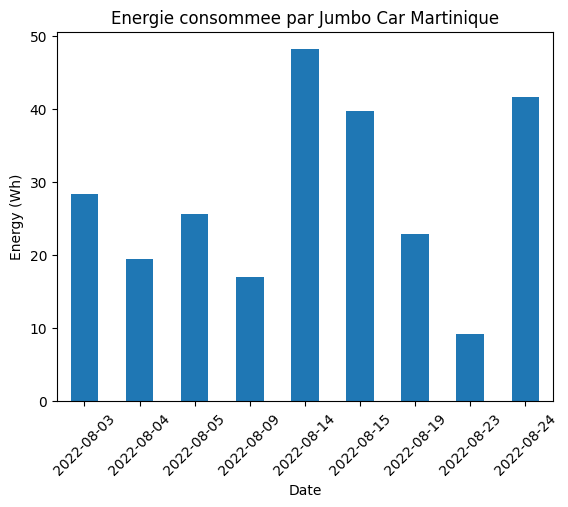

In [50]:
bar_energy = test_CPO_energy.plot(kind= 'bar')
bar_energy.set_ylabel('Energy (Wh)')
bar_energy.set_title('Energie consommee par '+ test)
bar_energy.set_xticklabels(pd.to_datetime(test_CPO_energy.index).date,rotation = 45)

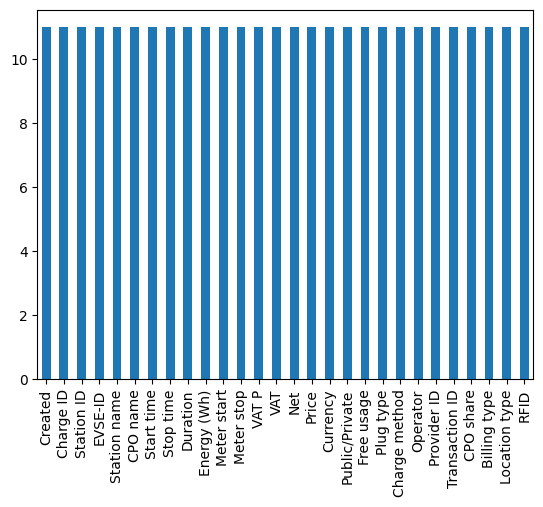

In [52]:
bar_count = test_CPO_count.plot(kind='bar')